In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import decimate, butter, lfilter, filtfilt, freqz

In [2]:
# binary data to load
bin_path = os.path.join("D:","SortingTest","24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1", 
                       "24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_imec0", 
                       "24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_t0.imec0.ap.bin")

# open binary file, read only, dimensions are 385 x unknown number of samples
binf = open(bin_path, mode='rb')
bin_samples = os.path.getsize(bin_path)

# parameters for LFP conversion
byte_num = 2
chan_num = 385
fs = 30000
lowcut = 500
downrate = 30
chunk_dur = 60*fs # number of time points to convert at a time
step_bytes = byte_num*chan_num # number of bytes per time point
bin_dur = bin_samples//step_bytes # number of time points in binary file
lfp_dur = bin_dur//downrate # number of time points in LFP file

# create butterworth filter
b,a = butter(2,  lowcut/(fs/2), 'low')

# initialize binary data to write
lfp_path = bin_path.replace('.ap.bin', '.lfp.bin')
lfpf = open(lfp_path, mode='wb')

# convert to LFP, in 1 minute chunks, 
chunks = np.arange(0, bin_dur, chunk_dur).astype(np.int64)
if chunks[-1] != bin_dur:
    chunks = np.append(chunks, bin_dur)

lfp_keep = np.arange(0, bin_dur, downrate).astype(np.int64)
for i in tqdm(range(len(chunks)-1)):
    binf.seek(chunks[i]*step_bytes)
    chunk_len = chunks[i+1]-chunks[i]
    bin_data = np.fromfile(binf, dtype='int16', count=chunk_len*chan_num)
    bin_data = bin_data.reshape((chunk_len, chan_num))
    lfp_data = bin_data.copy()
    lfp_data[:,:-1] = filtfilt(b, a, bin_data[:,:-1], axis=0)
    keep_inds = np.where(np.isin(np.arange(chunks[i], chunks[i+1]).astype(int), 
                                 lfp_keep))[0]
    lfp_data = lfp_data[keep_inds]
    lfpf.write(lfp_data.tobytes())

binf.close()
lfpf.close()

  5%|▌         | 1/20 [00:05<01:48,  5.71s/it]

(10000, 385)


 10%|█         | 2/20 [00:11<01:41,  5.63s/it]

(10000, 385)


 10%|█         | 2/20 [00:16<02:29,  8.29s/it]


KeyboardInterrupt: 

In [3]:
lfpf = open(lfp_path, mode='rb')
lfp_data = np.fromfile(lfpf, dtype='int16', count=-1)
lfp_data = lfp_data.reshape((-1, chan_num))

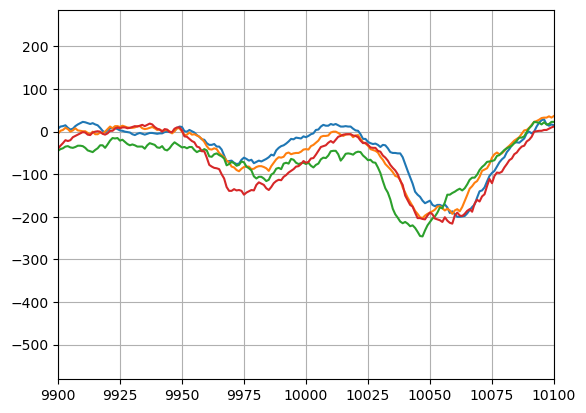

In [8]:
plt.plot(lfp_data[:,[100,200,300,0]])
plt.xlim(9900, 10100)
plt.grid()

In [ ]:
for i in tqdm(range(293)):
    bin_data = np.fromfile(binf, dtype='int16', count=385*30000*60)
    bin_data = bin_data.reshape((30000*60, 385))
    plt.plot(bin_data[:5000,100])
    plt.show()

In [3]:

# list samples to keep from chunks
lfp_keep = np.arange(0, samples, downrate)
lfp_offset = 0
for i in tqdm(range(len(chunks)-1)):
    chunk_start = int(chunks[i])
    chunk_end = int(chunks[i+1])
    chunk = bin_data[chunk_start:chunk_end]
    chunk_lfp = filtfilt(b, a, chunk[:,:-1], axis=0)
    chunk_lfp = np.concatenate((chunk_lfp, chunk[:,-1].reshape([-1,1])), axis=1)
    keep_inds = np.where(np.isin(np.arange(chunk_start, chunk_end), lfp_keep))[0]
    lfp_data[lfp_offset:(lfp_offset+len(keep_inds))] = chunk_lfp[keep_inds]
    lfp_offset += len(keep_inds)

 31%|███       | 90/294 [1:22:53<3:07:52, 55.26s/it]


KeyboardInterrupt: 

In [11]:
total = np.concatenate((chunk1, chunk_lfp[keep_inds]), axis=0)

In [16]:
total.shape

(120000, 385)

(59990.0, 60010.0)

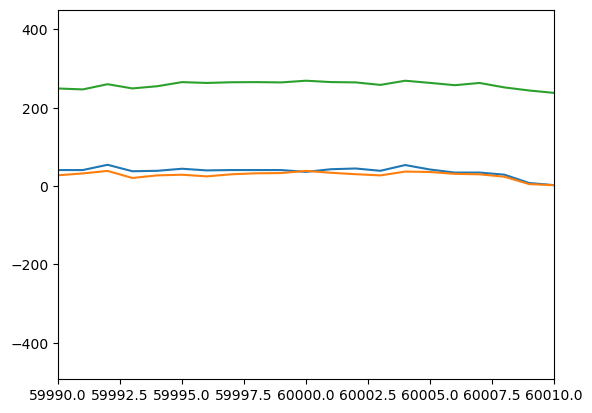

In [25]:
plt.plot(total[:,[0,100,383]])
plt.xlim([59990, 60010])

In [9]:
chunk1 = chunk_lfp[keep_inds].copy()

In [4]:
test= np.arange(lfp_offset, lfp_offset+len(keep_inds))
test.shape

(1800000,)

In [3]:
chunk_lfp.shape

(1800000, 385)

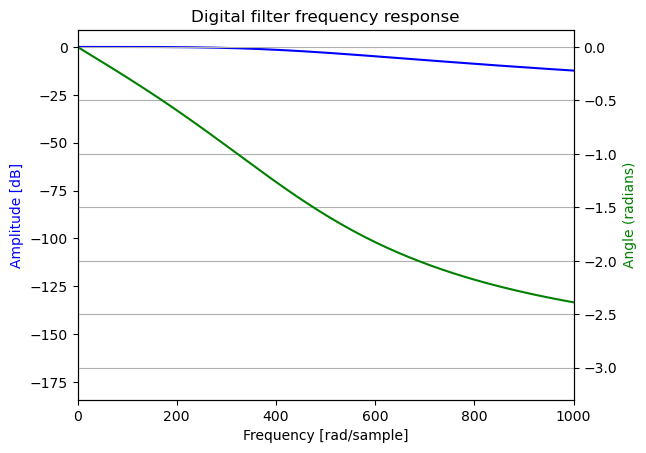

In [27]:
# low pass filter data with cutoff at 500 Hz
b,a = butter(2,  500/15000, 'low')

# visualize filter
w, h = freqz(b, a, worN=2000, fs=30000)

fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')

ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')
ax1.set_xlim([0, 1000])
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid(True)
plt.show()

In [28]:
temp = bin_data[0:30000,:]
temp_filt = filtfilt(b,a,temp[:,100])
temp_down = temp_filt[::10]



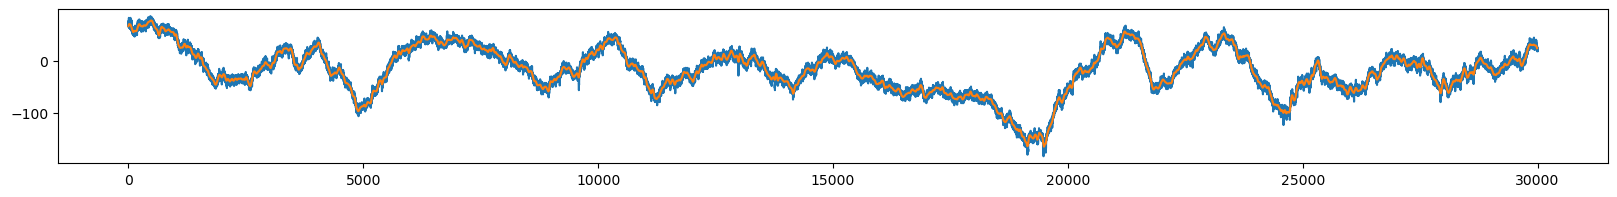

In [29]:
plt.figure(figsize=(20,2))
plt.plot(temp[:,100])
plt.plot(np.arange(0,30000,10),temp_down)

In [6]:
with open(bin_path, 'rb') as f:
    # read binary data into numpy array with dtype int16 and skip every 385 entries
    # do not use np.fromfile
    flength = os.path.getsize(bin_path)/(2*385)
    data = np.zeros(int(flength), dtype='int16')
    for i in range(int(flength)):
        
        data[i] = f.read(1)
        if i == 0:
            data = data.reshape((1, 385))
        else:
            data = np.vstack((data, data.reshape((1, 385))))
        f.seek(384, 1)



<class '_io.BufferedReader'>


In [3]:
nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): channel(0), time(0)
    variables(dimensions): 
    groups: 